In [151]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

In [153]:
# dataset: https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014
data = pd.read_csv('LD2011_2014.txt', sep=";", index_col=0, parse_dates=True, decimal=',')
num_timeseries = data.shape[1]
data.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [241]:
data_kw = data.resample('2H').sum() / 8
timeseries = []
num_timeseries = data_kw.shape[1]
for i in range(num_timeseries):
    timeseries.append(np.trim_zeros(data_kw.iloc[10000:11000,i], trim='f'))

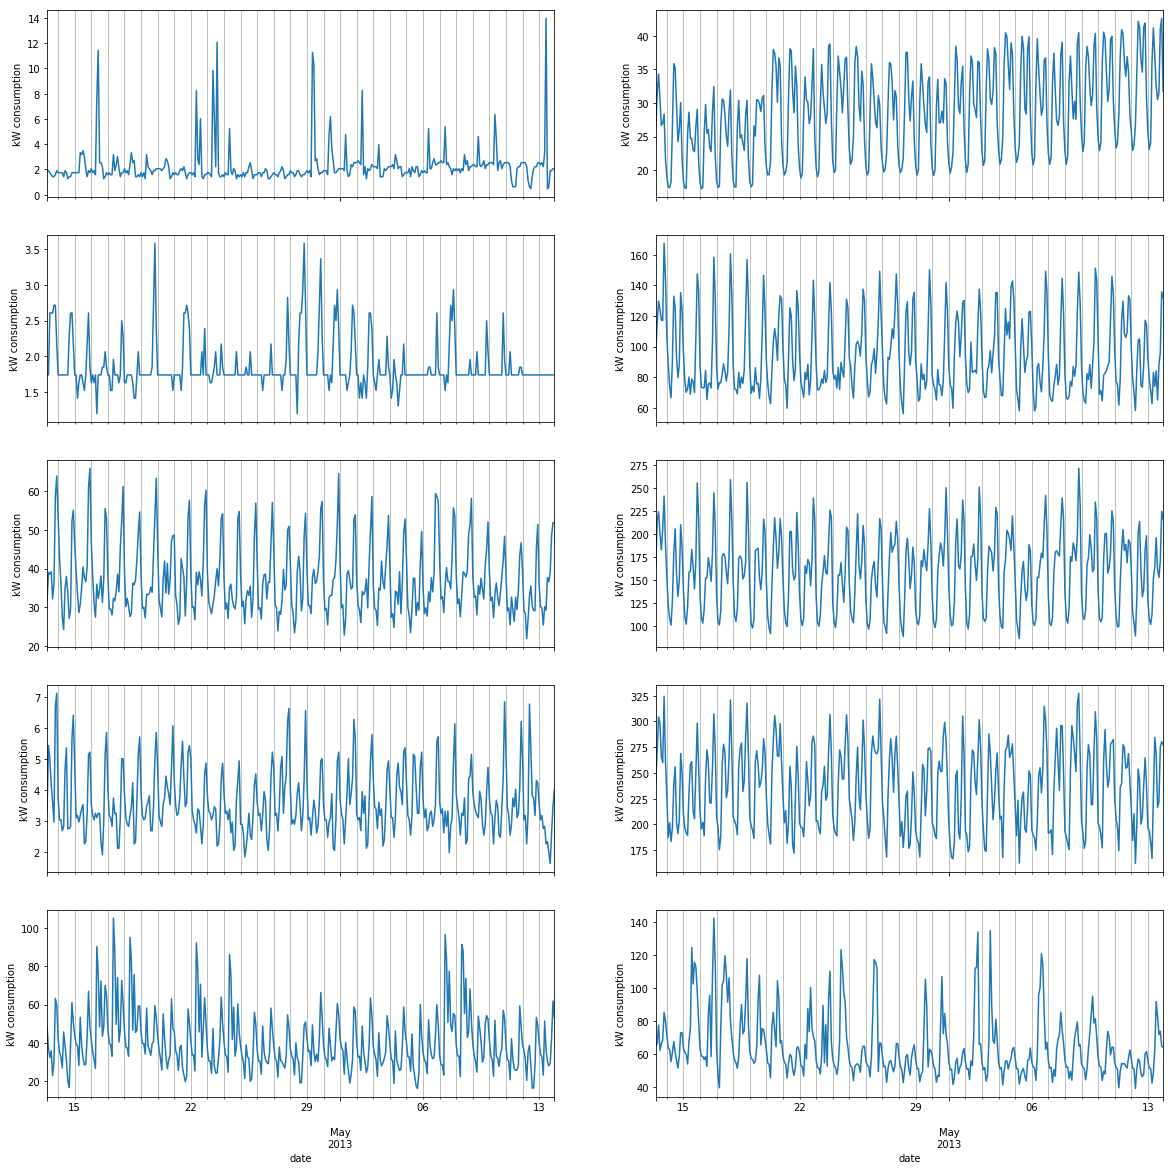

In [215]:
fig, axs = plt.subplots(5, 2, figsize=(20, 20), sharex=True)
axx = axs.ravel()
for i in range(0, 10):
    timeseries[i].loc["2013-04-13":"2013-05-13"].plot(ax=axx[i])
    axx[i].set_xlabel("date")    
    axx[i].set_ylabel("kW consumption")   
    axx[i].grid(which='minor', axis='x')

In [242]:
# we use 2 hour frequency for the time series
freq = '2H'
len(timeseries[i].loc["2013-04-13":"2013-07-13"])

1000

In [243]:
start_dataset = pd.Timestamp("2013-04-13 00:00:00", freq=freq)
end_training = pd.Timestamp("2013-06-13 00:00:00", freq=freq)
end_testing = pd.Timestamp("2013-07-13 00:00:00", freq=freq)

In [244]:
training_data = [
    {
        "start": str(start_dataset),
        "target": ts[start_dataset:end_training - 1].tolist()  # We use -1, because pandas indexing includes the upper bound 
    }
    for ts in timeseries
]
print(len(training_data))

370


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  


In [245]:
num_test_windows = 4

test_data = [
    {
        "start": str(end_training),
        "target": ts[end_training: end_testing].tolist()
    }
    for ts in timeseries
]
len(test_data[0]['target'])

272

In [220]:
def write_dicts_to_file(path, data):
    with open(path, 'wb') as fp:
        for d in data:
            fp.write(json.dumps(d).encode("utf-8"))
            fp.write("\n".encode('utf-8'))

In [161]:
write_dicts_to_file("train.json", training_data)
write_dicts_to_file("test.json", test_data)

In [143]:
#https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption
data_individual = pd.read_csv('household_power_consumption.txt', sep=";", index_col=0,
                              parse_dates=True, decimal=',', na_values=['?'])
data_individual.shape

(2075259, 8)

In [144]:
data_individual['Sub_metering_1'] = data_individual['Sub_metering_1'].astype('float')
data_individual['Sub_metering_2'] = data_individual['Sub_metering_2'].astype('float')
data_individual['Sub_metering_3'] = data_individual['Sub_metering_3'].astype('float')
data_individual.dtypes

Time                      object
Global_active_power       object
Global_reactive_power     object
Voltage                   object
Global_intensity          object
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object

In [145]:
data_kw_household = data_individual.resample('1D').sum()

In [146]:
data_kw_household['total_reading'] = data_kw_household['Sub_metering_1'] + data_kw_household['Sub_metering_2'] + data_kw_household['Sub_metering_3']

In [147]:
years = ['2007','2008', '2009']
file = open("individual_household_train.json", "a")
for year in years:
    # One JSON sample per line
    line = "\"start\":\"{} 00:00:00\",\"target\":{}".format(year, data_kw_household[year]['total_reading'].tolist())
    file.write('{'+line+'}\n')
file.close()


# Given the consumption in the last 30 days, you predict the next 30 days

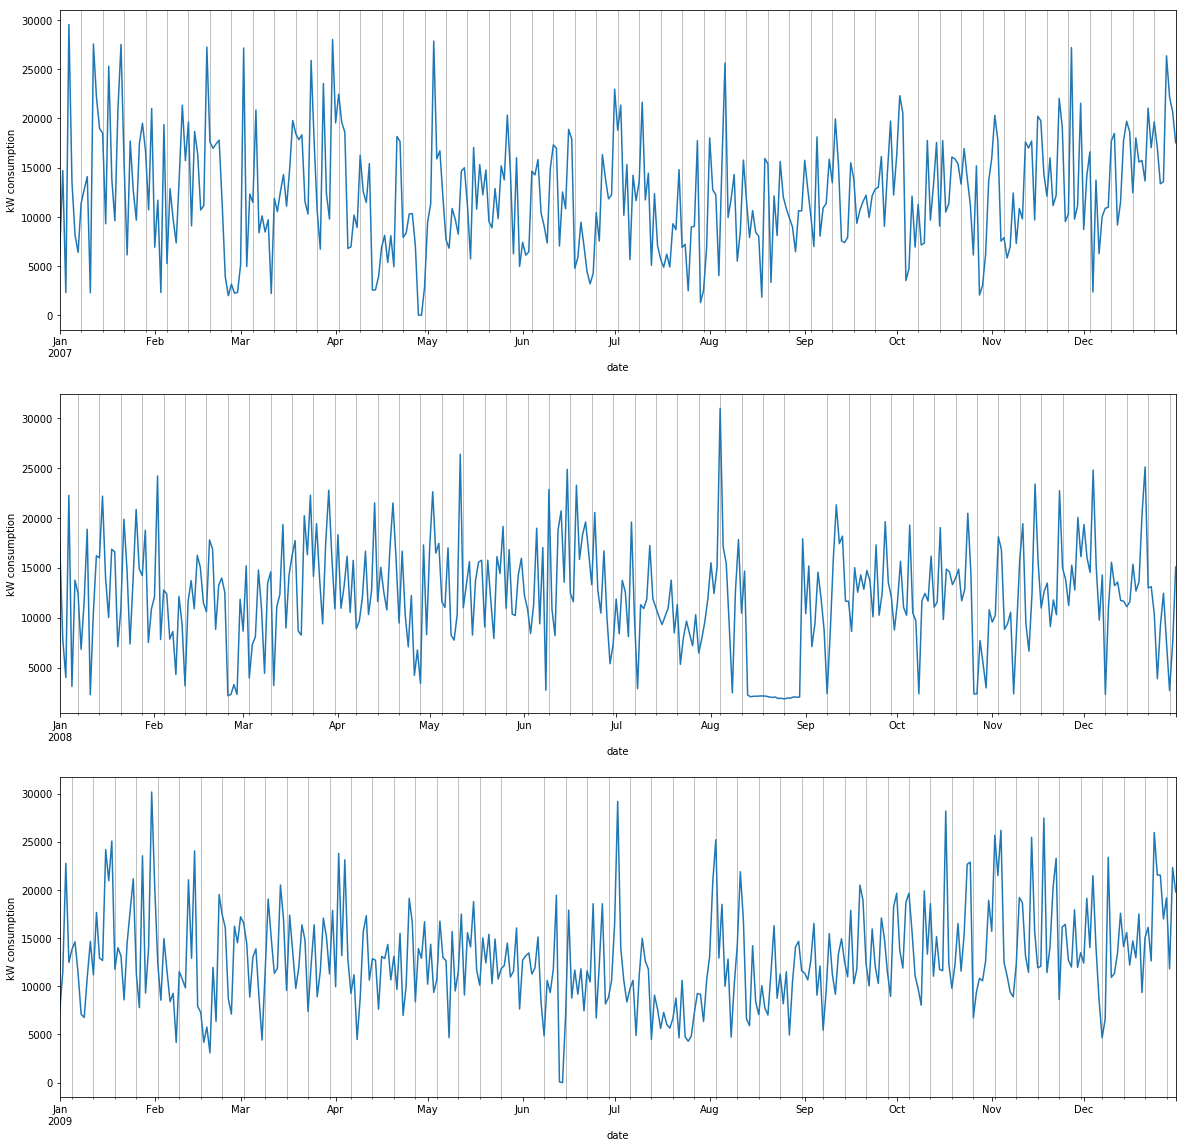

In [148]:
fig, axs = plt.subplots(3, 1, figsize=(20, 20))
axx = axs.ravel()
for i in range(0, 3):
    data_kw_household['total_reading'].loc[years[i]].plot(ax=axx[i])
    axx[i].set_xlabel("date")    
    axx[i].set_ylabel("kW consumption")   
    axx[i].grid(which='minor', axis='x')

In [149]:
years = ['2010']
file = open("individual_household_test.json", "a")
for year in years:
    # One JSON sample per line
    line = "\"start\":\"{} 00:00:00\",\"target\":{}".format(year, data_kw_household[year]['total_reading'].tolist())
    file.write('{'+line+'}\n')
file.close()

In [304]:
import requests
import json
def get_prediction(data):
    url = 'https://2b8pgrcpx9.execute-api.us-east-1.amazonaws.com/time-series-AICamp/time-series-aicamp'
    r = requests.post(url, data=json.dumps(data))
    response = getattr(r,'_content').decode("utf-8")
    #print(response)
    return response

In [317]:
# Focus on household 1
house = 1
predictions = []
for a in range(0,10):
    test_sample = {}
    test_sample = {"instances": [test_data[house].copy()]}
    test_sample["instances"][0]["target"] = test_data[house]["target"][a:a+100]
    test_sample["configuration"] =  {"output_types": ["mean",
                                                      "quantiles"
                                                     ],
                                     "quantiles": ["0.1",
                                                   "0.9"
                                                  ]
                                    }
    prediction_sample = json.loads(get_prediction(test_sample))['body']['predictions'][0]['quantiles']['0.9']
    #prediction_sample = json.loads(get_prediction(test_sample))['body']['predictions'][0]['mean']
    predictions.append(prediction_sample)

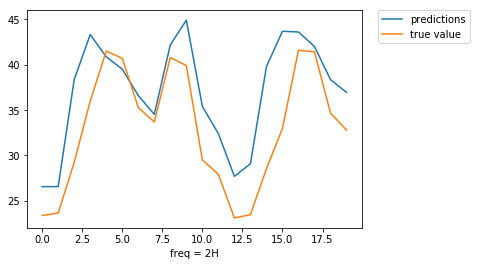

In [320]:
import matplotlib.pyplot as plt
plt.plot(predictions[9], label="predictions")
plt.plot(test_data[house]["target"][109:129], label="true value")
plt.xlabel('freq = 2H')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


In [313]:
rmse = np.sqrt(np.mean((np.array(predictions[0]) - np.array(test_data[house]["target"][100:120]))**2))

In [314]:
rmse

3.1468874310733854

In [299]:
np.sqrt(np.mean((np.array(predictions[0]) - np.array(test_data[house]["target"][100:120]))**2))

2.7175919508518867